<a href="https://colab.research.google.com/github/marinabar/hugging_face/blob/main/baseline_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports



In [1]:
!pip install -U transformers
!pip install accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 43.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 50.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.2/251.2 kB 3.9 MB/s eta 0:00:00


In [2]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.6 MB/s eta 0:00:00


In [3]:
!pip install evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 1.5 MB/s eta 0:00:00


In [36]:
from huggingface_hub import notebook_login
notebook_login()

Import preferred dataset

In [ ]:
from datasets import load_dataset

dataset = load_dataset("food101", split="train")
#create test split
dataset = dataset.train_test_split(test_size=0.2)

In [14]:
dataset = dataset.train_test_split(test_size=0.2)

In [15]:
dataset["train"][19]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x340>,
 'label': 65}

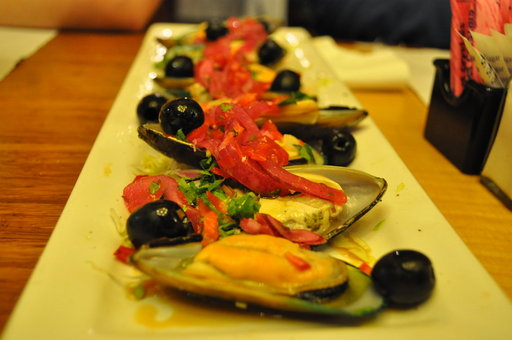

In [16]:
dataset["train"][19]["image"]

In [17]:
labels = dataset["train"].features["label"].names

In [18]:
dataset['train'].features

{'image': Image(decode=True, id=None),
 'label': ClassLabel(names=['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheesecake', 'cheese_plate', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lo

Create dicts mapping id to label name

In [19]:
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

In [21]:
batch_size = 64
model_config='google/vit-base-patch16-224-in21k'

Here we are using ViT's config

### Augment data

In [23]:
from transformers import set_seed

set_seed(42)

In [24]:
from transformers import AutoImageProcessor

image_processor  = AutoImageProcessor.from_pretrained(model_config)
image_processor

ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [25]:
from torchvision.transforms import CenterCrop, Compose, Normalize, RandomHorizontalFlip, RandomResizedCrop, Resize, ToTensor

normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
if "height" in image_processor.size:
    size = (image_processor.size["height"], image_processor.size["width"])
    crop_size = size
    max_size = None
elif "shortest_edge" in image_processor.size:
    size = image_processor.size["shortest_edge"]
    crop_size = (size, size)
    max_size = image_processor.size.get("longest_edge")

train_transforms = Compose(
        [
            Resize(size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

val_transforms = Compose(
        [
            Resize(size),
            ToTensor(),
            normalize,
        ]
    )

def preprocess_train(examples):
    """Apply train_transforms across a batch."""
    examples["pixel_values"] = [
        train_transforms(image.convert("RGB")) for image in examples["image"]
    ]
    return examples

def preprocess_val(examples):
    """Apply val_transforms across a batch."""
    examples["pixel_values"] = [val_transforms(image.convert("RGB")) for image in examples["image"]]
    return examples

Huggingface function to automatically map augmentation function and convert image to tensors

In [26]:
train_ds = dataset['train']
val_ds = dataset['test']

In [27]:
train_ds.set_transform(preprocess_train)
val_ds.set_transform(preprocess_val)

### Define metrics and analyzing function

In [28]:
import evaluate

accuracy = evaluate.load("accuracy")

In [29]:
import numpy as np

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

### Define model

In [30]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

model = AutoModelForImageClassification.from_pretrained(
    model_config,
    num_labels=len(labels),
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes = True, # provide this to fine-tune an already fine-tuned checkpoint
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [31]:
model

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

In [32]:
for name, param in model.named_parameters():
    if 'classifier' not in name:
      param.requires_grad=False

In [ ]:
for name, param in model.named_parameters():
    print(name,param.requires_grad)

In [34]:
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [37]:
# define hyperparameters
training_args = TrainingArguments(
    "foodievit", #name of the model we are going to save
    remove_unused_columns=False, # set as False otherwise will drop image coljmns
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=5,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=True,
    hub_model_id="m1b/foodievit"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=image_processor, #pre processing function
    compute_metrics=compute_metrics,# metrics function
    data_collator=collate_fn,
)

In [38]:
results=trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
0,4.309700,4.294118,0.490759
1,3.961300,3.957428,0.646205
2,3.731100,3.726790,0.677624
4,3.589500,3.592883,0.688581
4,3.538900,3.549708,0.690891


In [39]:
metrics = trainer.evaluate()
# some nice to haves:
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** eval metrics *****
  epoch                   =       4.98
  eval_accuracy           =     0.6909
  eval_loss               =     3.5497
  eval_runtime            = 0:04:16.70
  eval_samples_per_second =     59.016
  eval_steps_per_second   =      0.923


## Evaluate:

In [40]:
from PIL import Image
import requests

url = 'https://images.eatsmarter.com/sites/default/files/styles/1600x1200/public/american-style-clam-chowder-576468.jpg'
image = Image.open(requests.get(url, stream=True).raw)

In [4]:
from transformers import AutoModelForImageClassification, AutoImageProcessor

repo_name = "nateraw/food"

image_processor = AutoImageProcessor.from_pretrained(repo_name)
model = AutoModelForImageClassification.from_pretrained(repo_name)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [43]:
encoding = image_processor(image.convert("RGB"), return_tensors="pt")

In [47]:
encoding = encoding.to("cuda")

In [49]:
import torch
# forward pass
with torch.no_grad():
    outputs = model(**encoding)
    logits = outputs.logits

#get probabilities
prob=torch.nn.functional.softmax(logits, dim=1) #convert logits to prob
topprob=prob.sort(descending=True)[0][0][:5].tolist() # get top 5 prob
print(prob[0][79])
# get top five categories
top5=logits.argsort(descending=True)[0][:5].tolist()

print(*[f"Predicted {i+1} class: {id2label[(top5[i])]} - probability : {round(topprob[i], 4)} \n" for i in range(5)])

tensor(0.0081, device='cuda:0')
Predicted 1 class: clam_chowder - probability : 0.0527 
 Predicted 2 class: oysters - probability : 0.0171 
 Predicted 3 class: lobster_roll_sandwich - probability : 0.0163 
 Predicted 4 class: french_onion_soup - probability : 0.0141 
 Predicted 5 class: lobster_bisque - probability : 0.0136 



In [ ]:
data = load_dataset("food101", split="validation[:500]")

In [ ]:
from evaluate import evaluator
task_evaluator = evaluator("image-classification")

eval_results = task_evaluator.compute(
    model_or_pipeline=model,
    data=data,
    label_mapping=label2id,

    feature_extractor=image_processor
)

In [ ]:
print(eval_results)

{'accuracy': 0.966, 'total_time_in_seconds': 12.404484629000763, 'samples_per_second': 40.30800270662089, 'latency_in_seconds': 0.024808969258001527}
